## Bibiliothèque

In [1]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from resnet import resnet_layer, resnet_v1
from Distiller import Distiller_AdaIn, Distiller
from tensorflow.keras.preprocessing.image import ImageDataGenerator

%matplotlib inline
seed = tf.random.set_seed(10)


2022-05-11 16:46:32.026856: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-11 16:46:32.026891: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## Utils

In [2]:
def plot_hist_kd(hist, figname):
    #History
    plt.figure(figsize=(20,7))
    plt.subplot(121)
    plt.plot(hist.history['sparse_categorical_accuracy'], label = "train accur")
    plt.plot(hist.history['val_sparse_categorical_accuracy'], label = "Val accur")
    
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title("Accuracy")
    plt.grid()
    plt.legend()


    plt.subplot(122)
    plt.plot(hist.history['student_loss'], label = "student Loss")
    plt.plot(hist.history['val_student_loss'], label = "Val loss")
    plt.xlabel('Epochs')
    plt.ylabel('Student Loss')
    plt.title("Loss")
    plt.grid()
    plt.legend()
    
    plt.savefig(figname)
    
    plt.show()
    
def plot_hist(hist, figname):
    #History
    plt.figure(figsize=(20,7))
    plt.subplot(121)
    plt.plot(hist.history['sparse_categorical_accuracy'], label = "train accur")
    plt.plot(hist.history['val_sparse_categorical_accuracy'], label = "Val accur")
    
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title("Accuracy")
    plt.grid()
    plt.legend()


    plt.subplot(122)
    plt.plot(hist.history['loss'], label = "Loss")
    plt.plot(hist.history['val_loss'], label = "Val loss")
    plt.xlabel('Epochs')
    plt.ylabel('Student Loss')
    plt.title("Loss")
    plt.grid()
    plt.legend()
    
    plt.savefig(figname)
    
    plt.show()

## Loading cifar10 Dataset

In [3]:
print("================ Data Loading ================")
(x_train, y_train),(x_test, y_test) = tf.keras.datasets.cifar10.load_data()

# Normalize data.
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# Data shapes
print("x_train shape:", x_train.shape)
print("x_test shape:", x_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)
print("")

================ Data Loading ================
x_train shape: (50000, 32, 32, 3)
x_test shape: (10000, 32, 32, 3)
y_train shape: (50000, 1)
y_test shape: (10000, 1)



## Loading Resnet26 Teacher model

In [4]:
print("")
print("================ Loading teacher model ================")
teacher = tf.keras.models.load_model("Resnet26_from_logits_datagen")
print("Evaluation of Teacher model!")
teacher.evaluate(x_test, y_test)
print("")



================ Loading teacher model ================


2022-05-11 16:46:47.676138: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-05-11 16:46:47.676170: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-05-11 16:46:47.676264: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (tall12): /proc/driver/nvidia/version does not exist
2022-05-11 16:46:47.678071: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Evaluation of Teacher model!
313/313 [==============================] - 13s 39ms/step - loss: 0.4362 - sparse_categorical_accuracy: 0.9084



## Creating a data augmentation process

In [5]:
print("================ Building dataGen ================")
datagen = ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    zca_epsilon=1e-06,
    rotation_range=45,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=False,
)

datagen.fit(x_train)

================ Building dataGen ================


## Building callbacks

In [6]:
model_save = tf.keras.callbacks.ModelCheckpoint(
    "/callback/callback_save",
    monitor='val_student_loss',
    verbose=1,
    save_best_only=True,
    save_weights_only=True,
    mode='auto',
    save_freq='epoch',
    options=None,
    initial_value_threshold=None,
)

lr_reduce = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_student_loss',
    factor=0.1,
    patience=10,
    verbose=1,
    mode='min',
    
    min_delta=0.0001,
    cooldown=0,
    min_lr=0.000001,
)


## Knowledge distillation

In [7]:
BATCH_SIZE = 32
EPOCHS = 100
A = [ 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
lr = 0.1


Epoch 1/100
1562/1562 [==============================] - 93s 57ms/step - sparse_categorical_accuracy: 0.3661 - student_loss: 1.9836 - loss: 0.7752 - val_sparse_categorical_accuracy: 0.3708 - val_student_loss: 2.3899 - lr: 0.1000
Epoch 2/100
1562/1562 [==============================] - 92s 58ms/step - sparse_categorical_accuracy: 0.4895 - student_loss: 1.7023 - loss: 0.6126 - val_sparse_categorical_accuracy: 0.4315 - val_student_loss: 1.7051 - lr: 0.1000
Epoch 3/100
1562/1562 [==============================] - 93s 58ms/step - sparse_categorical_accuracy: 0.5454 - student_loss: 1.5583 - loss: 0.5390 - val_sparse_categorical_accuracy: 0.5154 - val_student_loss: 2.7260 - lr: 0.1000
Epoch 4/100
1562/1562 [==============================] - 92s 58ms/step - sparse_categorical_accuracy: 0.5833 - student_loss: 1.4430 - loss: 0.4902 - val_sparse_categorical_accuracy: 0.5346 - val_student_loss: 3.4469 - lr: 0.1000
Epoch 5/100
1562/1562 [==============================] - 88s 55ms/step - sparse_cate

Epoch 36/100
1562/1562 [==============================] - 94s 58ms/step - sparse_categorical_accuracy: 0.7944 - student_loss: 0.6772 - loss: 0.2135 - val_sparse_categorical_accuracy: 0.7919 - val_student_loss: 1.4952 - lr: 0.0100
Epoch 37/100
1562/1562 [==============================] - 91s 57ms/step - sparse_categorical_accuracy: 0.7981 - student_loss: 0.6665 - loss: 0.2104 - val_sparse_categorical_accuracy: 0.7875 - val_student_loss: 1.5214 - lr: 0.0100
Epoch 38/100
1562/1562 [==============================] - 93s 58ms/step - sparse_categorical_accuracy: 0.7973 - student_loss: 0.6615 - loss: 0.2087 - val_sparse_categorical_accuracy: 0.7906 - val_student_loss: 1.5313 - lr: 0.0100
Epoch 39/100
1562/1562 [==============================] - 93s 58ms/step - sparse_categorical_accuracy: 0.7969 - student_loss: 0.6698 - loss: 0.2097 - val_sparse_categorical_accuracy: 0.7930 - val_student_loss: 1.5255 - lr: 0.0100
Epoch 40/100
1562/1562 [==============================] - 92s 57ms/step - sparse

1562/1562 [==============================] - 94s 58ms/step - sparse_categorical_accuracy: 0.8049 - student_loss: 0.6406 - loss: 0.2022 - val_sparse_categorical_accuracy: 0.7939 - val_student_loss: 1.5285 - lr: 1.0000e-05
Epoch 69/100
1562/1562 [==============================] - 96s 59ms/step - sparse_categorical_accuracy: 0.8031 - student_loss: 0.6451 - loss: 0.2028 - val_sparse_categorical_accuracy: 0.7937 - val_student_loss: 1.5261 - lr: 1.0000e-05
Epoch 70/100
1562/1562 [==============================] - 95s 58ms/step - sparse_categorical_accuracy: 0.8021 - student_loss: 0.6504 - loss: 0.2018 - val_sparse_categorical_accuracy: 0.7932 - val_student_loss: 1.5273 - lr: 1.0000e-05
Epoch 71/100
1562/1562 [==============================] - 96s 59ms/step - sparse_categorical_accuracy: 0.8057 - student_loss: 0.6365 - loss: 0.2016 - val_sparse_categorical_accuracy: 0.7944 - val_student_loss: 1.5317 - lr: 1.0000e-05
Epoch 72/100
1562/1562 [==============================] - 94s 58ms/step - spa

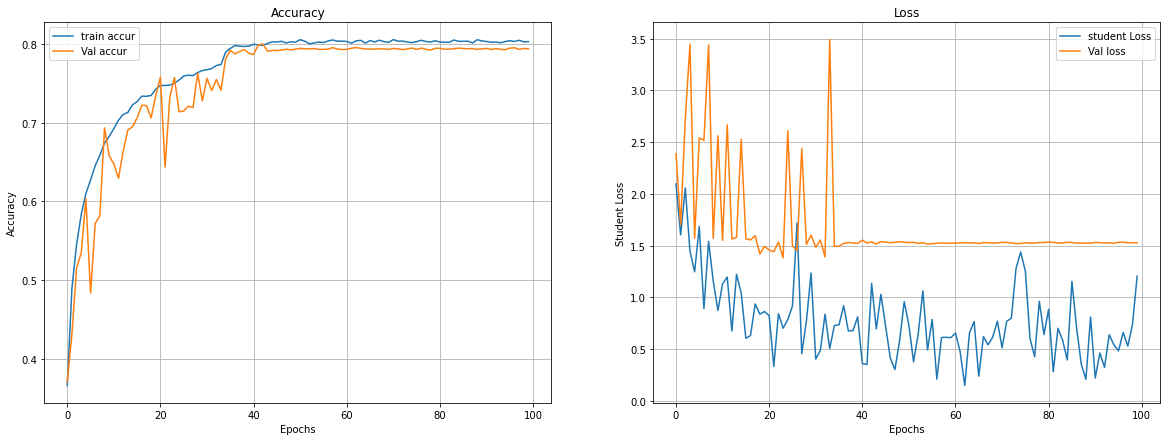

Saving model 


2022-05-11 19:23:41.738204: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: Resnet8_KD_notebook_alpha0.1/assets
Saving Done !
Saving Weights 
Saving Done !

End !
Epoch 1/100
1562/1562 [==============================] - 96s 58ms/step - sparse_categorical_accuracy: 0.3794 - student_loss: 1.8064 - loss: 0.8798 - val_sparse_categorical_accuracy: 0.4329 - val_student_loss: 3.8513 - lr: 0.1000
Epoch 2/100
1562/1562 [==============================] - 94s 58ms/step - sparse_categorical_accuracy: 0.4980 - student_loss: 1.5397 - loss: 0.7124 - val_sparse_categorical_accuracy: 0.4074 - val_student_loss: 3.5799 - lr: 0.1000
Epoch 3/100
1562/1562 [==============================] - 92s 56ms/step - sparse_categorical_accuracy: 0.5541 - student_loss: 1.4019 - loss: 0.6347 - val_sparse_categorical_accuracy: 0.5593 - val_student_loss: 1.3388 - lr: 0.1000
Epoch 4/100
1562/1562 [==============================] - 96s 59ms/step - sparse_categorical_accuracy: 0.5884 - student_loss: 1.3140 - loss: 0.5870 - val_sparse_categorical_accuracy: 0.5372 - 

1562/1562 [==============================] - 94s 58ms/step - sparse_categorical_accuracy: 0.7721 - student_loss: 0.7314 - loss: 0.3023 - val_sparse_categorical_accuracy: 0.7602 - val_student_loss: 1.4253 - lr: 1.0000e-03
Epoch 35/100
1562/1562 [==============================] - 94s 57ms/step - sparse_categorical_accuracy: 0.7731 - student_loss: 0.7261 - loss: 0.3024 - val_sparse_categorical_accuracy: 0.7644 - val_student_loss: 1.4236 - lr: 1.0000e-03
Epoch 36/100
1562/1562 [==============================] - 93s 57ms/step - sparse_categorical_accuracy: 0.7750 - student_loss: 0.7217 - loss: 0.3008 - val_sparse_categorical_accuracy: 0.7638 - val_student_loss: 1.4299 - lr: 1.0000e-03
Epoch 37/100
1562/1562 [============================>.] - ETA: 0s - sparse_categorical_accuracy: 0.7743 - student_loss: 0.7243 - loss: 0.3010
Epoch 37: ReduceLROnPlateau reducing learning rate to 9.999999310821295e-05.
1562/1562 [==============================] - 93s 57ms/step - sparse_categorical_accuracy: 0.

1562/1562 [==============================] - 94s 58ms/step - sparse_categorical_accuracy: 0.7718 - student_loss: 0.7318 - loss: 0.3030 - val_sparse_categorical_accuracy: 0.7630 - val_student_loss: 1.4309 - lr: 1.0000e-06
Epoch 67/100
1562/1562 [==============================] - 95s 58ms/step - sparse_categorical_accuracy: 0.7725 - student_loss: 0.7251 - loss: 0.3002 - val_sparse_categorical_accuracy: 0.7613 - val_student_loss: 1.4277 - lr: 1.0000e-06
Epoch 68/100
1562/1562 [==============================] - 96s 59ms/step - sparse_categorical_accuracy: 0.7741 - student_loss: 0.7181 - loss: 0.2995 - val_sparse_categorical_accuracy: 0.7633 - val_student_loss: 1.4268 - lr: 1.0000e-06
Epoch 69/100
1562/1562 [==============================] - 98s 60ms/step - sparse_categorical_accuracy: 0.7733 - student_loss: 0.7275 - loss: 0.3021 - val_sparse_categorical_accuracy: 0.7617 - val_student_loss: 1.4259 - lr: 1.0000e-06
Epoch 70/100
1562/1562 [==============================] - 95s 58ms/step - spa

313/313 [==============================] - 4s 14ms/step - sparse_categorical_accuracy: 0.7622 - student_loss: 1.6467

 =============== History Plot ===============


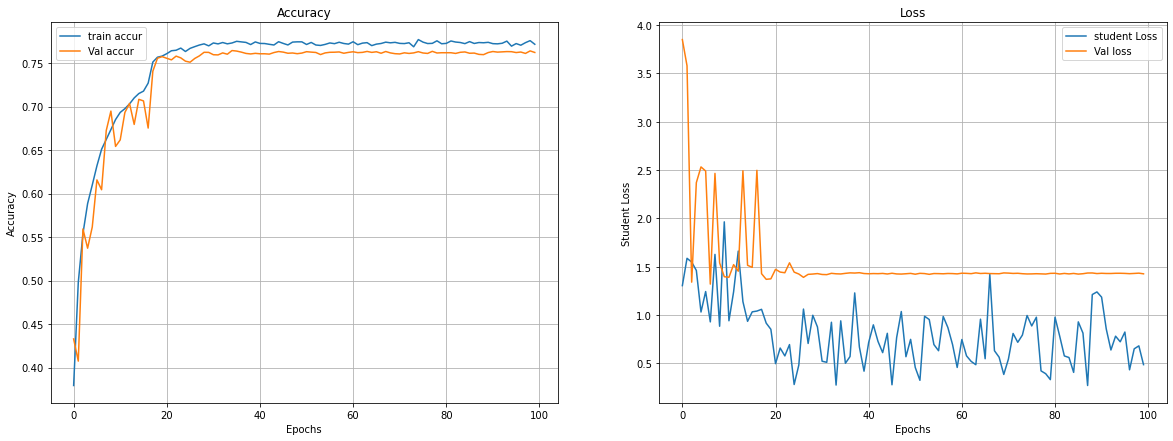

Saving model 
INFO:tensorflow:Assets written to: Resnet8_KD_notebook_alpha0.2/assets
Saving Done !
Saving Weights 
Saving Done !

End !
Epoch 1/100
1562/1562 [==============================] - 97s 59ms/step - sparse_categorical_accuracy: 0.3835 - student_loss: 1.7407 - loss: 0.9931 - val_sparse_categorical_accuracy: 0.4367 - val_student_loss: 2.4782 - lr: 0.1000
Epoch 2/100
1562/1562 [==============================] - 91s 56ms/step - sparse_categorical_accuracy: 0.5026 - student_loss: 1.4696 - loss: 0.8167 - val_sparse_categorical_accuracy: 0.5573 - val_student_loss: 2.5236 - lr: 0.1000
Epoch 3/100
1562/1562 [==============================] - 93s 57ms/step - sparse_categorical_accuracy: 0.5465 - student_loss: 1.3540 - loss: 0.7354 - val_sparse_categorical_accuracy: 0.5855 - val_student_loss: 3.5247 - lr: 0.1000
Epoch 4/100
1562/1562 [==============================] - 90s 55ms/step - sparse_categorical_accuracy: 0.5851 - student_loss: 1.2524 - loss: 0.6753 - val_sparse_categorical_accur

1562/1562 [==============================] - 93s 57ms/step - sparse_categorical_accuracy: 0.7724 - student_loss: 0.7008 - loss: 0.3554 - val_sparse_categorical_accuracy: 0.7600 - val_student_loss: 2.3579 - lr: 1.0000e-03
Epoch 34/100
1562/1562 [==============================] - 96s 59ms/step - sparse_categorical_accuracy: 0.7722 - student_loss: 0.7058 - loss: 0.3573 - val_sparse_categorical_accuracy: 0.7597 - val_student_loss: 2.3598 - lr: 1.0000e-03
Epoch 35/100
1563/1562 [==============================] - ETA: 0s - sparse_categorical_accuracy: 0.7748 - student_loss: 0.6997 - loss: 0.3553
Epoch 35: ReduceLROnPlateau reducing learning rate to 9.999999310821295e-05.
1562/1562 [==============================] - 88s 54ms/step - sparse_categorical_accuracy: 0.7748 - student_loss: 0.6995 - loss: 0.3552 - val_sparse_categorical_accuracy: 0.7641 - val_student_loss: 2.3591 - lr: 1.0000e-03
Epoch 36/100
1562/1562 [==============================] - 89s 54ms/step - sparse_categorical_accuracy: 0.

1562/1562 [==============================] - 94s 57ms/step - sparse_categorical_accuracy: 0.7740 - student_loss: 0.6981 - loss: 0.3545 - val_sparse_categorical_accuracy: 0.7641 - val_student_loss: 2.3567 - lr: 1.0000e-06
Epoch 66/100
1562/1562 [==============================] - 92s 56ms/step - sparse_categorical_accuracy: 0.7743 - student_loss: 0.7069 - loss: 0.3568 - val_sparse_categorical_accuracy: 0.7599 - val_student_loss: 2.3659 - lr: 1.0000e-06
Epoch 67/100
1562/1562 [==============================] - 93s 56ms/step - sparse_categorical_accuracy: 0.7750 - student_loss: 0.7023 - loss: 0.3557 - val_sparse_categorical_accuracy: 0.7591 - val_student_loss: 2.3553 - lr: 1.0000e-06
Epoch 68/100
1562/1562 [==============================] - 97s 58ms/step - sparse_categorical_accuracy: 0.7724 - student_loss: 0.6997 - loss: 0.3552 - val_sparse_categorical_accuracy: 0.7595 - val_student_loss: 2.3607 - lr: 1.0000e-06
Epoch 69/100
1562/1562 [==============================] - 93s 56ms/step - spa

313/313 [==============================] - 4s 11ms/step - sparse_categorical_accuracy: 0.7615 - student_loss: 1.6736

 =============== History Plot ===============


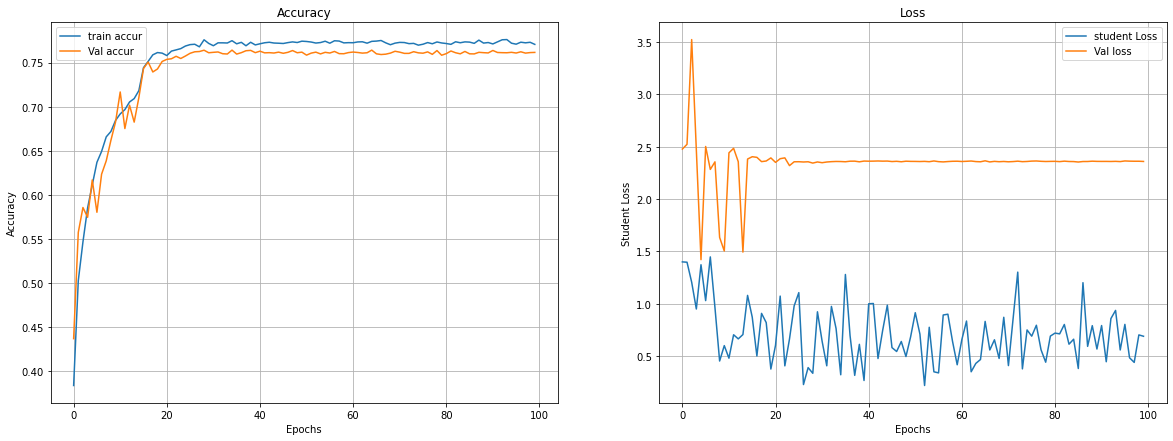

Saving model 
INFO:tensorflow:Assets written to: Resnet8_KD_notebook_alpha0.3/assets
Saving Done !
Saving Weights 
Saving Done !

End !
Epoch 1/100
1562/1562 [==============================] - 101s 60ms/step - sparse_categorical_accuracy: 0.3711 - student_loss: 1.7354 - loss: 1.1114 - val_sparse_categorical_accuracy: 0.4526 - val_student_loss: 1.4969 - lr: 0.1000
Epoch 2/100
1562/1562 [==============================] - 96s 58ms/step - sparse_categorical_accuracy: 0.4882 - student_loss: 1.4590 - loss: 0.9263 - val_sparse_categorical_accuracy: 0.4589 - val_student_loss: 3.5989 - lr: 0.1000
Epoch 3/100
1562/1562 [==============================] - 95s 57ms/step - sparse_categorical_accuracy: 0.5402 - student_loss: 1.3327 - loss: 0.8372 - val_sparse_categorical_accuracy: 0.5765 - val_student_loss: 1.4976 - lr: 0.1000
Epoch 4/100
1562/1562 [==============================] - 94s 57ms/step - sparse_categorical_accuracy: 0.5701 - student_loss: 1.2555 - loss: 0.7808 - val_sparse_categorical_accu

1562/1562 [==============================] - 95s 58ms/step - sparse_categorical_accuracy: 0.7693 - student_loss: 0.7019 - loss: 0.4169 - val_sparse_categorical_accuracy: 0.7658 - val_student_loss: 2.4293 - lr: 1.0000e-03
Epoch 34/100
1562/1562 [==============================] - 94s 57ms/step - sparse_categorical_accuracy: 0.7701 - student_loss: 0.6938 - loss: 0.4125 - val_sparse_categorical_accuracy: 0.7662 - val_student_loss: 2.4338 - lr: 1.0000e-03
Epoch 35/100
1562/1562 [==============================] - 95s 57ms/step - sparse_categorical_accuracy: 0.7683 - student_loss: 0.7019 - loss: 0.4156 - val_sparse_categorical_accuracy: 0.7643 - val_student_loss: 2.4392 - lr: 1.0000e-03
Epoch 36/100
1563/1562 [==============================] - ETA: 0s - sparse_categorical_accuracy: 0.7696 - student_loss: 0.6957 - loss: 0.4141
Epoch 36: ReduceLROnPlateau reducing learning rate to 9.999999310821295e-05.
1562/1562 [==============================] - 95s 58ms/step - sparse_categorical_accuracy: 0.

1562/1562 [==============================] - 95s 58ms/step - sparse_categorical_accuracy: 0.7675 - student_loss: 0.7005 - loss: 0.4150 - val_sparse_categorical_accuracy: 0.7638 - val_student_loss: 2.4420 - lr: 1.0000e-06
Epoch 66/100
1562/1562 [==============================] - 95s 58ms/step - sparse_categorical_accuracy: 0.7703 - student_loss: 0.6936 - loss: 0.4124 - val_sparse_categorical_accuracy: 0.7643 - val_student_loss: 2.4415 - lr: 1.0000e-06
Epoch 67/100
1562/1562 [==============================] - 97s 59ms/step - sparse_categorical_accuracy: 0.7705 - student_loss: 0.6959 - loss: 0.4132 - val_sparse_categorical_accuracy: 0.7644 - val_student_loss: 2.4323 - lr: 1.0000e-06
Epoch 68/100
1562/1562 [==============================] - 96s 58ms/step - sparse_categorical_accuracy: 0.7670 - student_loss: 0.7032 - loss: 0.4170 - val_sparse_categorical_accuracy: 0.7637 - val_student_loss: 2.4330 - lr: 1.0000e-06
Epoch 69/100
1562/1562 [==============================] - 98s 60ms/step - spa

313/313 [==============================] - 4s 14ms/step - sparse_categorical_accuracy: 0.7641 - student_loss: 1.6968

 =============== History Plot ===============


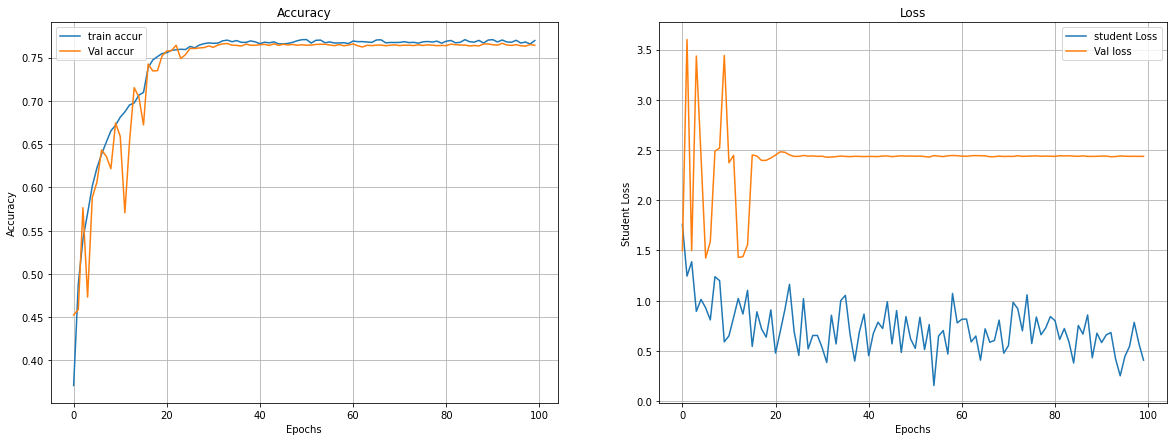

Saving model 
INFO:tensorflow:Assets written to: Resnet8_KD_notebook_alpha0.4/assets
Saving Done !
Saving Weights 
Saving Done !

End !
Epoch 1/100
1562/1562 [==============================] - 93s 56ms/step - sparse_categorical_accuracy: 0.3659 - student_loss: 1.7343 - loss: 1.2254 - val_sparse_categorical_accuracy: 0.4542 - val_student_loss: 1.5524 - lr: 0.1000
Epoch 2/100
1562/1562 [==============================] - 92s 56ms/step - sparse_categorical_accuracy: 0.4882 - student_loss: 1.4428 - loss: 1.0168 - val_sparse_categorical_accuracy: 0.4282 - val_student_loss: 1.5015 - lr: 0.1000
Epoch 3/100
1562/1562 [==============================] - 96s 59ms/step - sparse_categorical_accuracy: 0.5452 - student_loss: 1.2946 - loss: 0.9091 - val_sparse_categorical_accuracy: 0.5286 - val_student_loss: 1.4387 - lr: 0.1000
Epoch 4/100
1562/1562 [==============================] - 93s 57ms/step - sparse_categorical_accuracy: 0.5833 - student_loss: 1.2061 - loss: 0.8407 - val_sparse_categorical_accur

1562/1562 [============================>.] - ETA: 0s - sparse_categorical_accuracy: 0.7607 - student_loss: 0.7070 - loss: 0.4773
Epoch 33: ReduceLROnPlateau reducing learning rate to 9.999999310821295e-05.
1562/1562 [==============================] - 97s 59ms/step - sparse_categorical_accuracy: 0.7607 - student_loss: 0.7067 - loss: 0.4771 - val_sparse_categorical_accuracy: 0.7533 - val_student_loss: 2.5407 - lr: 1.0000e-03
Epoch 34/100
1562/1562 [==============================] - 94s 57ms/step - sparse_categorical_accuracy: 0.7587 - student_loss: 0.7081 - loss: 0.4774 - val_sparse_categorical_accuracy: 0.7515 - val_student_loss: 2.5435 - lr: 1.0000e-04
Epoch 35/100
1562/1562 [==============================] - 99s 60ms/step - sparse_categorical_accuracy: 0.7610 - student_loss: 0.7085 - loss: 0.4772 - val_sparse_categorical_accuracy: 0.7518 - val_student_loss: 2.5402 - lr: 1.0000e-04
Epoch 36/100
1562/1562 [==============================] - 97s 59ms/step - sparse_categorical_accuracy: 0.

1562/1562 [==============================] - 97s 59ms/step - sparse_categorical_accuracy: 0.7618 - student_loss: 0.7054 - loss: 0.4759 - val_sparse_categorical_accuracy: 0.7515 - val_student_loss: 2.5389 - lr: 1.0000e-06
Epoch 66/100
1562/1562 [==============================] - 97s 59ms/step - sparse_categorical_accuracy: 0.7600 - student_loss: 0.7063 - loss: 0.4758 - val_sparse_categorical_accuracy: 0.7540 - val_student_loss: 2.5388 - lr: 1.0000e-06
Epoch 67/100
1562/1562 [==============================] - 96s 58ms/step - sparse_categorical_accuracy: 0.7640 - student_loss: 0.6989 - loss: 0.4724 - val_sparse_categorical_accuracy: 0.7523 - val_student_loss: 2.5366 - lr: 1.0000e-06
Epoch 68/100
1562/1562 [==============================] - 96s 58ms/step - sparse_categorical_accuracy: 0.7648 - student_loss: 0.6981 - loss: 0.4720 - val_sparse_categorical_accuracy: 0.7535 - val_student_loss: 2.5351 - lr: 1.0000e-06
Epoch 69/100
1562/1562 [==============================] - 95s 58ms/step - spa

313/313 [==============================] - 4s 12ms/step - sparse_categorical_accuracy: 0.7530 - student_loss: 1.7209

 =============== History Plot ===============


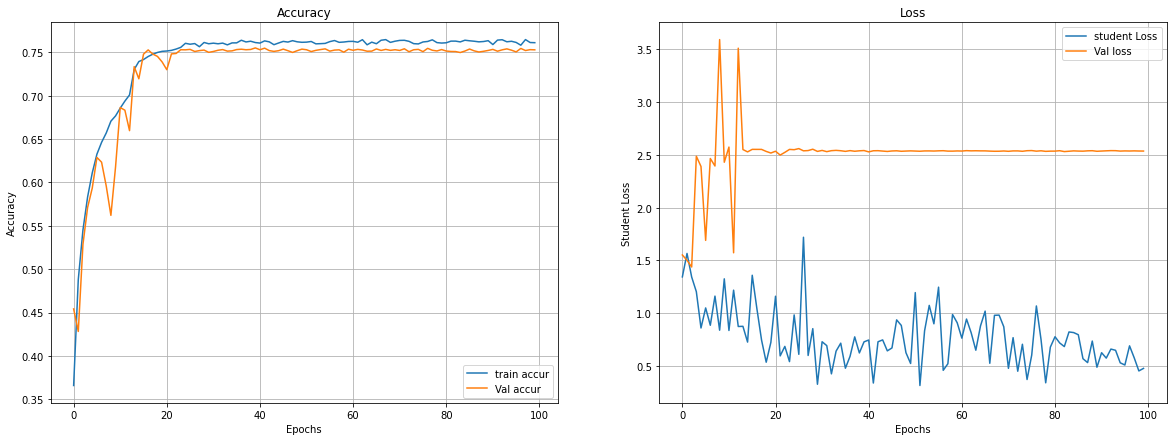

Saving model 
INFO:tensorflow:Assets written to: Resnet8_KD_notebook_alpha0.5/assets
Saving Done !
Saving Weights 
Saving Done !

End !
Epoch 1/100
1562/1562 [==============================] - 99s 59ms/step - sparse_categorical_accuracy: 0.3640 - student_loss: 1.7328 - loss: 1.3298 - val_sparse_categorical_accuracy: 0.3469 - val_student_loss: 3.6587 - lr: 0.1000
Epoch 2/100
1562/1562 [==============================] - 95s 57ms/step - sparse_categorical_accuracy: 0.4817 - student_loss: 1.4462 - loss: 1.1143 - val_sparse_categorical_accuracy: 0.5325 - val_student_loss: 2.4644 - lr: 0.1000
Epoch 3/100
1562/1562 [==============================] - 94s 57ms/step - sparse_categorical_accuracy: 0.5297 - student_loss: 1.3260 - loss: 1.0183 - val_sparse_categorical_accuracy: 0.4694 - val_student_loss: 1.6072 - lr: 0.1000
Epoch 4/100
1562/1562 [==============================] - 96s 58ms/step - sparse_categorical_accuracy: 0.5610 - student_loss: 1.2452 - loss: 0.9547 - val_sparse_categorical_accur

1562/1562 [==============================] - 96s 58ms/step - sparse_categorical_accuracy: 0.7692 - student_loss: 0.6798 - loss: 0.5064 - val_sparse_categorical_accuracy: 0.7636 - val_student_loss: 2.3987 - lr: 1.0000e-03
Epoch 34/100
1562/1562 [==============================] - 96s 58ms/step - sparse_categorical_accuracy: 0.7725 - student_loss: 0.6669 - loss: 0.4984 - val_sparse_categorical_accuracy: 0.7624 - val_student_loss: 2.3934 - lr: 1.0000e-03
Epoch 35/100
1562/1562 [==============================] - 94s 57ms/step - sparse_categorical_accuracy: 0.7718 - student_loss: 0.6698 - loss: 0.4999 - val_sparse_categorical_accuracy: 0.7608 - val_student_loss: 2.3894 - lr: 1.0000e-03
Epoch 36/100
1562/1562 [==============================] - 95s 57ms/step - sparse_categorical_accuracy: 0.7731 - student_loss: 0.6671 - loss: 0.4980 - val_sparse_categorical_accuracy: 0.7634 - val_student_loss: 2.3904 - lr: 1.0000e-03
Epoch 37/100
1562/1562 [==============================] - 94s 56ms/step - spa

1562/1562 [==============================] - 98s 59ms/step - sparse_categorical_accuracy: 0.7713 - student_loss: 0.6673 - loss: 0.4977 - val_sparse_categorical_accuracy: 0.7661 - val_student_loss: 2.3951 - lr: 1.0000e-06
Epoch 66/100
1562/1562 [==============================] - 98s 59ms/step - sparse_categorical_accuracy: 0.7757 - student_loss: 0.6580 - loss: 0.4917 - val_sparse_categorical_accuracy: 0.7679 - val_student_loss: 2.3927 - lr: 1.0000e-06
Epoch 67/100
1562/1562 [==============================] - 94s 57ms/step - sparse_categorical_accuracy: 0.7734 - student_loss: 0.6679 - loss: 0.4971 - val_sparse_categorical_accuracy: 0.7678 - val_student_loss: 2.3945 - lr: 1.0000e-06
Epoch 68/100
1562/1562 [==============================] - 97s 59ms/step - sparse_categorical_accuracy: 0.7775 - student_loss: 0.6593 - loss: 0.4933 - val_sparse_categorical_accuracy: 0.7643 - val_student_loss: 2.3934 - lr: 1.0000e-06
Epoch 69/100
1562/1562 [==============================] - 100s 61ms/step - sp

313/313 [==============================] - 4s 13ms/step - sparse_categorical_accuracy: 0.7647 - student_loss: 1.6796

 =============== History Plot ===============


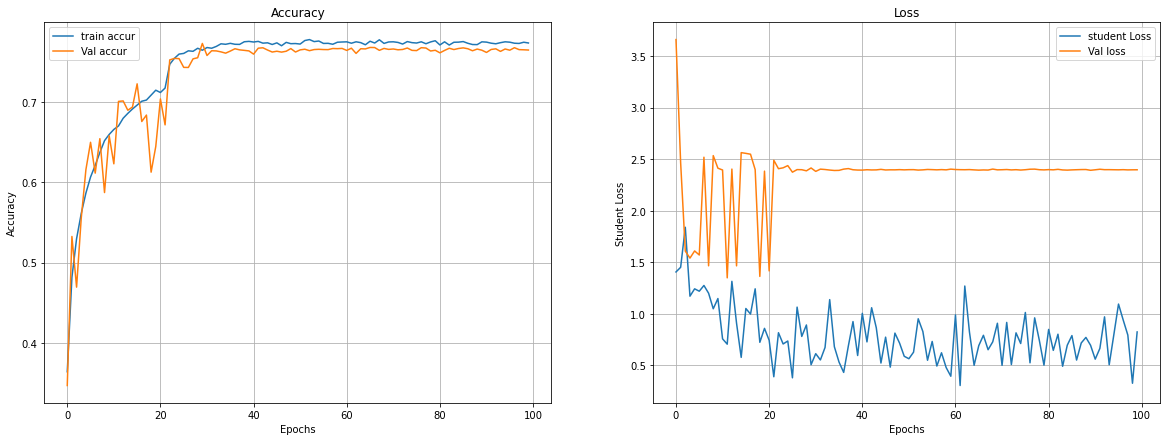

Saving model 
INFO:tensorflow:Assets written to: Resnet8_KD_notebook_alpha0.6/assets
Saving Done !
Saving Weights 
Saving Done !

End !
Epoch 1/100
1562/1562 [==============================] - 98s 58ms/step - sparse_categorical_accuracy: 0.3536 - student_loss: 1.7646 - loss: 1.4614 - val_sparse_categorical_accuracy: 0.3561 - val_student_loss: 1.6541 - lr: 0.1000
Epoch 2/100
1562/1562 [==============================] - 95s 58ms/step - sparse_categorical_accuracy: 0.4740 - student_loss: 1.4599 - loss: 1.2130 - val_sparse_categorical_accuracy: 0.4565 - val_student_loss: 1.4846 - lr: 0.1000
Epoch 3/100
1562/1562 [==============================] - 96s 58ms/step - sparse_categorical_accuracy: 0.5271 - student_loss: 1.3271 - loss: 1.1027 - val_sparse_categorical_accuracy: 0.4781 - val_student_loss: 1.4881 - lr: 0.1000
Epoch 4/100
1562/1562 [==============================] - 95s 57ms/step - sparse_categorical_accuracy: 0.5563 - student_loss: 1.2505 - loss: 1.0388 - val_sparse_categorical_accur

1562/1562 [==============================] - 97s 59ms/step - sparse_categorical_accuracy: 0.7582 - student_loss: 0.7028 - loss: 0.5752 - val_sparse_categorical_accuracy: 0.7528 - val_student_loss: 2.4848 - lr: 1.0000e-03
Epoch 34/100
1562/1562 [==============================] - 95s 58ms/step - sparse_categorical_accuracy: 0.7604 - student_loss: 0.6959 - loss: 0.5711 - val_sparse_categorical_accuracy: 0.7545 - val_student_loss: 2.4810 - lr: 1.0000e-03
Epoch 35/100
1562/1562 [==============================] - 94s 57ms/step - sparse_categorical_accuracy: 0.7602 - student_loss: 0.6950 - loss: 0.5697 - val_sparse_categorical_accuracy: 0.7530 - val_student_loss: 2.4820 - lr: 1.0000e-03
Epoch 36/100
1562/1562 [============================>.] - ETA: 0s - sparse_categorical_accuracy: 0.7584 - student_loss: 0.7031 - loss: 0.5760
Epoch 36: ReduceLROnPlateau reducing learning rate to 9.999999310821295e-05.
1562/1562 [==============================] - 98s 59ms/step - sparse_categorical_accuracy: 0.

1562/1562 [==============================] - 97s 59ms/step - sparse_categorical_accuracy: 0.7580 - student_loss: 0.7008 - loss: 0.5743 - val_sparse_categorical_accuracy: 0.7546 - val_student_loss: 2.4837 - lr: 1.0000e-06
Epoch 66/100
1562/1562 [==============================] - 97s 59ms/step - sparse_categorical_accuracy: 0.7596 - student_loss: 0.6979 - loss: 0.5710 - val_sparse_categorical_accuracy: 0.7541 - val_student_loss: 2.4817 - lr: 1.0000e-06
Epoch 67/100
1562/1562 [==============================] - 95s 57ms/step - sparse_categorical_accuracy: 0.7588 - student_loss: 0.7001 - loss: 0.5733 - val_sparse_categorical_accuracy: 0.7562 - val_student_loss: 2.4848 - lr: 1.0000e-06
Epoch 68/100
1562/1562 [==============================] - 94s 57ms/step - sparse_categorical_accuracy: 0.7640 - student_loss: 0.6901 - loss: 0.5662 - val_sparse_categorical_accuracy: 0.7552 - val_student_loss: 2.4779 - lr: 1.0000e-06
Epoch 69/100
1562/1562 [==============================] - 95s 58ms/step - spa

313/313 [==============================] - 4s 11ms/step - sparse_categorical_accuracy: 0.7551 - student_loss: 1.6998

 =============== History Plot ===============


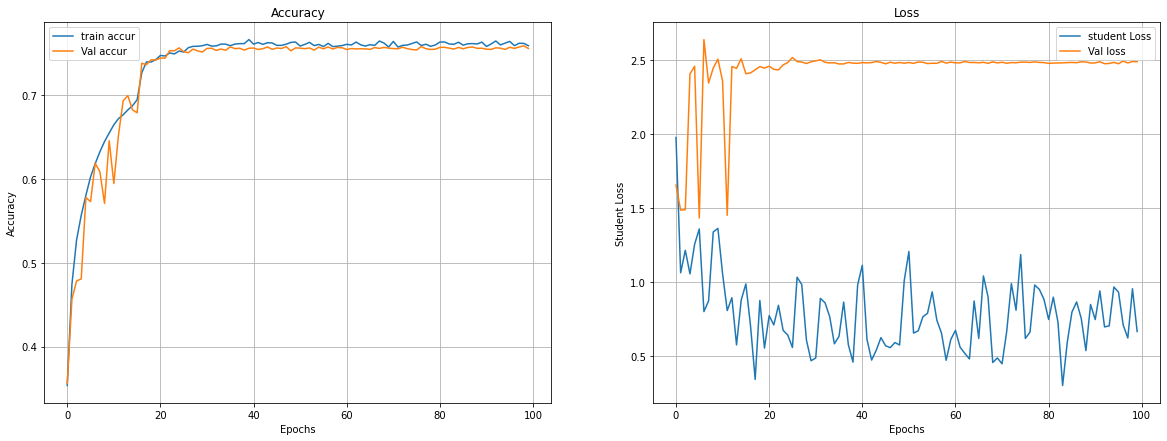

Saving model 
INFO:tensorflow:Assets written to: Resnet8_KD_notebook_alpha0.7/assets
Saving Done !
Saving Weights 
Saving Done !

End !
Epoch 1/100
1562/1562 [==============================] - 97s 57ms/step - sparse_categorical_accuracy: 0.3550 - student_loss: 1.7503 - loss: 1.5508 - val_sparse_categorical_accuracy: 0.4057 - val_student_loss: 3.7702 - lr: 0.1000
Epoch 2/100
1562/1562 [==============================] - 96s 58ms/step - sparse_categorical_accuracy: 0.4773 - student_loss: 1.4421 - loss: 1.2820 - val_sparse_categorical_accuracy: 0.5161 - val_student_loss: 3.4682 - lr: 0.1000
Epoch 3/100
1562/1562 [==============================] - 97s 58ms/step - sparse_categorical_accuracy: 0.5360 - student_loss: 1.2995 - loss: 1.1563 - val_sparse_categorical_accuracy: 0.5002 - val_student_loss: 2.3829 - lr: 0.1000
Epoch 4/100
1562/1562 [==============================] - 94s 57ms/step - sparse_categorical_accuracy: 0.5696 - student_loss: 1.2120 - loss: 1.0781 - val_sparse_categorical_accur

1562/1562 [==============================] - 93s 56ms/step - sparse_categorical_accuracy: 0.7655 - student_loss: 0.6786 - loss: 0.6006 - val_sparse_categorical_accuracy: 0.7545 - val_student_loss: 2.3900 - lr: 1.0000e-03
Epoch 34/100
1562/1562 [==============================] - 90s 55ms/step - sparse_categorical_accuracy: 0.7693 - student_loss: 0.6719 - loss: 0.5950 - val_sparse_categorical_accuracy: 0.7573 - val_student_loss: 2.3898 - lr: 1.0000e-03
Epoch 35/100
1562/1562 [==============================] - 93s 56ms/step - sparse_categorical_accuracy: 0.7663 - student_loss: 0.6764 - loss: 0.5990 - val_sparse_categorical_accuracy: 0.7571 - val_student_loss: 2.3800 - lr: 1.0000e-03
Epoch 36/100
1562/1562 [==============================] - 95s 58ms/step - sparse_categorical_accuracy: 0.7652 - student_loss: 0.6785 - loss: 0.6005 - val_sparse_categorical_accuracy: 0.7575 - val_student_loss: 2.3965 - lr: 1.0000e-03
Epoch 37/100
1562/1562 [==============================] - 92s 56ms/step - spa

1562/1562 [==============================] - 95s 57ms/step - sparse_categorical_accuracy: 0.7675 - student_loss: 0.6725 - loss: 0.5951 - val_sparse_categorical_accuracy: 0.7552 - val_student_loss: 2.3859 - lr: 1.0000e-06
Epoch 66/100
1562/1562 [==============================] - 100s 60ms/step - sparse_categorical_accuracy: 0.7679 - student_loss: 0.6700 - loss: 0.5933 - val_sparse_categorical_accuracy: 0.7559 - val_student_loss: 2.3926 - lr: 1.0000e-06
Epoch 67/100
1562/1562 [==============================] - 94s 57ms/step - sparse_categorical_accuracy: 0.7686 - student_loss: 0.6723 - loss: 0.5956 - val_sparse_categorical_accuracy: 0.7601 - val_student_loss: 2.3932 - lr: 1.0000e-06
Epoch 68/100
1562/1562 [==============================] - 93s 56ms/step - sparse_categorical_accuracy: 0.7682 - student_loss: 0.6721 - loss: 0.5947 - val_sparse_categorical_accuracy: 0.7553 - val_student_loss: 2.3883 - lr: 1.0000e-06
Epoch 69/100
1562/1562 [==============================] - 92s 55ms/step - sp

313/313 [==============================] - 4s 11ms/step - sparse_categorical_accuracy: 0.7573 - student_loss: 1.6532

 =============== History Plot ===============


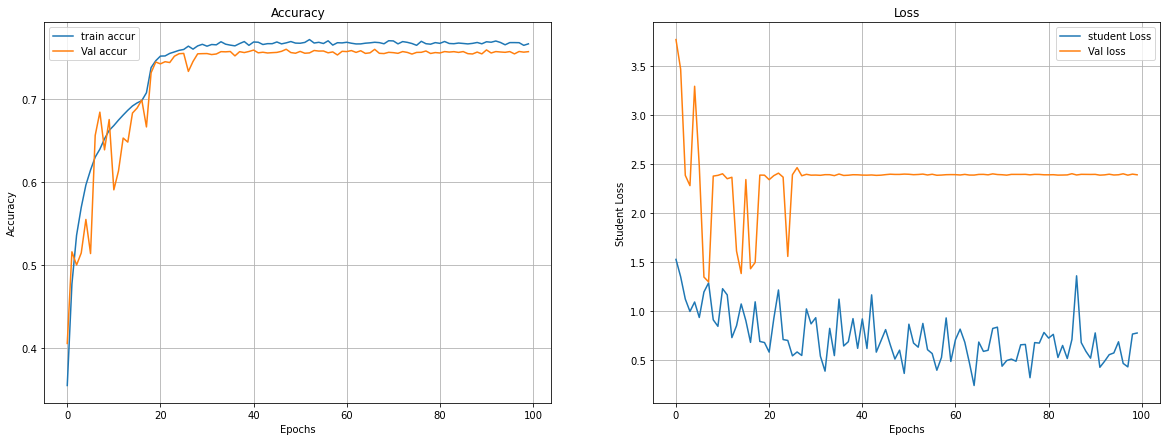

Saving model 
INFO:tensorflow:Assets written to: Resnet8_KD_notebook_alpha0.8/assets
Saving Done !
Saving Weights 
Saving Done !

End !
Epoch 1/100
1562/1562 [==============================] - 101s 58ms/step - sparse_categorical_accuracy: 0.3768 - student_loss: 1.7003 - loss: 1.6044 - val_sparse_categorical_accuracy: 0.4248 - val_student_loss: 3.6092 - lr: 0.1000
Epoch 2/100
1562/1562 [==============================] - 95s 57ms/step - sparse_categorical_accuracy: 0.4952 - student_loss: 1.4076 - loss: 1.3305 - val_sparse_categorical_accuracy: 0.4631 - val_student_loss: 3.4950 - lr: 0.1000
Epoch 3/100
1562/1562 [==============================] - 109s 67ms/step - sparse_categorical_accuracy: 0.5448 - student_loss: 1.2821 - loss: 1.2127 - val_sparse_categorical_accuracy: 0.5322 - val_student_loss: 1.4196 - lr: 0.1000
Epoch 4/100
1562/1562 [==============================] - 110s 68ms/step - sparse_categorical_accuracy: 0.5741 - student_loss: 1.2001 - loss: 1.1353 - val_sparse_categorical_ac

In [ ]:
for a in A:
    # Configuration du tensorboard
    NAME = f"Resnet8_kd_alpha_{a}_temp_{5}"
    tensorboard = tf.keras.callbacks.TensorBoard(log_dir = f"logs/{NAME}", 
                                                 histogram_freq = 1)
    
    student = resnet_v1(input_shape=(32, 32, 3), depth= 8)

    dist = Distiller(teacher, student)

    dist.compile(
        optimizer = tf.keras.optimizers.SGD(learning_rate=lr, momentum=0.9),
        metrics = [tf.keras.metrics.SparseCategoricalAccuracy()],
        distillation_loss_fn = tf.keras.losses.KLDivergence(),
        student_loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
        alpha = a,
        temperature = 5)

    # Train and evaluate on data.
    hist = dist.fit(datagen.flow(x_train, y_train, 
          batch_size = BATCH_SIZE),
          epochs=EPOCHS,
          steps_per_epoch = len(x_train)/BATCH_SIZE,
          validation_data =(x_test, y_test),
          workers =40,
          use_multiprocessing= True,
          callbacks = [lr_reduce, tensorboard],
          )


    dist.evaluate(x_test, y_test)
    print("")

    print(" =============== History Plot ===============")
    plot_hist_kd(hist, f"Resnet8_KD_notebook_alpha{a}.png")


    print("Saving model ")
    student.save(f"Resnet8_KD_notebook_alpha{a}")
    print("Saving Done !")

    print("Saving Weights ")
    student.save_weights(f"w_resnet8_alpha_{a}.h5")
    print("Saving Done !")
    print("")

    print("End !")